# 1. Build an image segmentation model using pytorch

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import torch
import cv2
from torch.nn import CrossEntropyLoss
import torch.nn as nn
from torch.optim import Adam
from skimage import io, transform
import torchvision
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, Dataset, random_split
from torchvision import transforms
import pandas as pd
import  torch.nn.functional as F
from torch import optim
from PIL import Image
import matplotlib.pyplot as plt
import lightning.pytorch  as pl
from torchvision import transforms as T
from tqdm import tqdm
import os
import albumentations as A
torch.manual_seed(0)

# 2. Train your model using [lung segmentation datasets](https://github.com/YoushanZhang/Lung_Segmentation)

In [2]:
imgdir = "Images/"

img = plt.imread(r"Images/Train/Images/1.png")
mask = plt.imread(r"Images/Train/Masks/1.png")
pred  = plt.imread("Images/Train/Predict/1.png")

img.shape, mask.shape, pred.shape

((1024, 1024), (1024, 1024), (512, 512))

In [3]:
train_img_paths = sorted(os.listdir("Images/Train/Images"))
train_mask_paths = sorted(os.listdir("Images/Train/Masks"))

valid_img_paths = sorted(os.listdir("Images/Test/Images"))
valid_mask_paths = sorted(os.listdir("Images/Test/Masks"))


train_img_paths.remove(".DS_Store")
train_img_paths.remove(".ipynb_checkpoints")

print("Checking if the images and masks are aligned")
print(train_img_paths == train_mask_paths)
print(valid_img_paths == valid_mask_paths)


Checking if the images and masks are aligned
True
True


In [4]:
class LungDataset(Dataset):
    def __init__(self, img_dir, img_paths, mask_paths, data = "Train", transforms=None):
        self.img_dir = img_dir 
        self.transforms = transforms
        self.data = data
        self.imgs = img_paths
        self.mask = mask_paths
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.img_dir, self.data, "Images", self.imgs[idx]))
        mask = Image.open(os.path.join(self.img_dir, self.data, "Masks", self.mask[idx]))

        if self.transforms:
            return self.transforms(img), self.transforms(mask)
        
        return img, mask
    
Img_size = 256  
def Otsu(img):
    mean = img.mean()
    img[img<= mean ] = 0
    img[img> mean] = 1
    return img
    
train_transforms = T.Compose([
    T.ToTensor(),
    T.Resize((Img_size, Img_size), antialias=True),
    T.ColorJitter(),
    T.RandomRotation(0.45),
    T.GaussianBlur(3)
])

valid_transforms = T.Compose([
    T.ToTensor(),
    T.Resize((Img_size, Img_size), antialias=True),
        T.GaussianBlur(3),
])
    
trainds = LungDataset(imgdir, train_img_paths, train_mask_paths, transforms=train_transforms,  data = "Train")
valds = LungDataset(imgdir, valid_img_paths, valid_mask_paths, transforms=valid_transforms, data = "Test")

batch_size = 35
pin_memory = True
n_workers = 0

traindl = DataLoader(trainds, batch_size=batch_size, shuffle=True, pin_memory=pin_memory, num_workers=n_workers)
valdl = DataLoader(valds, batch_size=batch_size, shuffle=False, pin_memory=pin_memory)

print("Train shape: ", len(trainds))
print("Test shape: ", len(valds))

Train shape:  800
Test shape:  200


Image shape: torch.Size([35, 1, 256, 256]), Mask shape: torch.Size([35, 1, 256, 256])


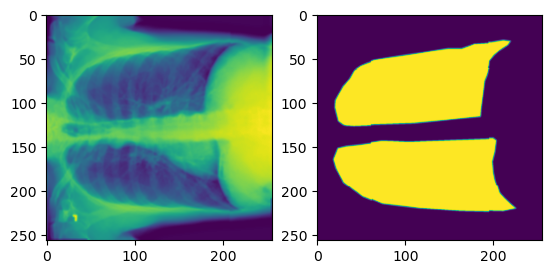

In [5]:
for img, mask  in traindl:
    print(f"Image shape: {img.shape}, Mask shape: {mask.shape}")
    break

fig, axis = plt.subplots(1, 2)
axis[0].imshow(img[0].swapaxes(0, 2))
axis[1].imshow(mask[0].swapaxes(0, 2));

In [6]:
class LungSegmentor(nn.Module):
    def __init__(self):
        super(LungSegmentor, self).__init__()
        self.rb1= nn.Sequential(
            nn.Conv2d(3, 9, 3, padding=0, stride=1),
            nn.BatchNorm2d(9),
            nn.LeakyReLU(0.2),
            nn.Conv2d(9, 9, 3, padding=1, stride=1),
            nn.BatchNorm2d(9),
            nn.ReLU()
        )
        
        self.rb2 = nn.Sequential(
            nn.Conv2d(9, 18, 3, padding=0),
            nn.BatchNorm2d(18),
            nn.LeakyReLU(0.2),
            nn.Conv2d(18, 18, 3, padding=1),
            nn.BatchNorm2d(18),
            nn.ReLU()
        )
        
        self.rb3 = nn.Sequential(
            nn.Conv2d(18, 36, 3, padding=0),
            nn.BatchNorm2d(36),
            nn.LeakyReLU(0.2),
            nn.Conv2d(36, 36, 3, padding=1),
            nn.BatchNorm2d(36),
            nn.ReLU()
        )
        self.conv1 = nn.Sequential(
        nn.Conv2d(1, 3, 3),
        nn.LeakyReLU(0.2),
        )

        self.conv2 = nn.Sequential(
        nn.Conv2d(3, 9, 3),
        nn.LeakyReLU(0.2),
        )
        self.conv3 = nn.Sequential(
        nn.Conv2d(9, 18, 3),
        nn.LeakyReLU(0.2),
        )
        self.conv4 = nn.Sequential(
        nn.Conv2d(18, 36, 3),
        nn.LeakyReLU(0.2),
        )     
        self.pool = nn.MaxPool2d(3)
#         self.pool = nn.AdaptiveMaxPool2d(3)
        self.decoder = nn.Sequential(
        nn.ConvTranspose2d(36, 18, kernel_size=3, stride=3, padding=5, output_padding=1),
        nn.LeakyReLU(0.1),
        nn.ConvTranspose2d(18, 9, kernel_size=3, stride=2, padding=2, output_padding=1),
        nn.LeakyReLU(0.1),
        nn.ConvTranspose2d(9, 1, kernel_size=2, stride=2, padding=3, output_padding=1),  
        nn.LeakyReLU(0.1) 
        )

    def forward(self, img):
        out = self.conv1(img)
        out = self.conv2(out) + self.rb1(out)
        out = self.pool(out)
        out = self.conv3(out) + self.rb2(out)
        out = self.pool(out)
        out = self.conv4(out) + self.rb3(out)
        out = self.decoder(out)
        out = F.interpolate(out, (Img_size, Img_size))
        out = F.sigmoid(out)
        return out
segmentor = LungSegmentor() 
segmentor(img).shape

torch.Size([35, 1, 256, 256])

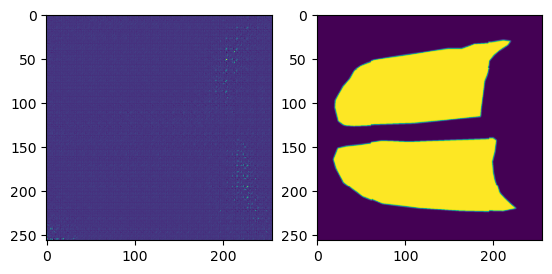

In [7]:
out = segmentor(img)

fig, axis = plt.subplots(1, 2)
axis[0].imshow(out[0].detach().numpy().swapaxes(0, 2))
axis[1].imshow(mask[0].swapaxes(0, 2));

In [8]:
class IoUScore(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoUScore, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return IoU

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

In [9]:
lr = 1e-3
device = "mps" if torch.backends.mps.is_available() else "cpu"
loss_fn   = DiceLoss()
iou = IoUScore()
# model = ResNet18().to(device)
model = LungSegmentor().to(device)
opt =  optim.Adam(model.parameters(), lr=lr)

num_epochs = 500
trainSteps = int(len(valds)/batch_size)
testSteps = int(len(valds)/batch_size)

train_loss = []
test_loss = []
test_iou = []
train_iou = []



for img, mask in valdl:
    img, mask = img.to(device), mask.to(device)
    res = model(img )
    print(res.shape)
    print("IOU score: ", iou(res, mask))
    print("Loss: ", loss_fn(res, mask))
    break

torch.Size([35, 1, 256, 256])
IOU score:  tensor(0.2619, device='mps:0', grad_fn=<DivBackward0>)
Loss:  tensor(0.5849, device='mps:0', grad_fn=<RsubBackward1>)


In [10]:
import mlflow
import mlflow.pytorch
from pathlib import Path
from mlflow import MlflowClient
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import Callback


# mlflow.set_tracking_uri("file:./ml-flow")
class PrintCallback(Callback):
    def on_train_start(self, trainer, pl_module):
        print("Training is started!")
    def on_train_end(self, trainer, pl_module):
        print("Training is done.")


class LungTrainer(pl.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()
        self.model = model
        self.save_hyperparameters(ignore=['model'])
        self.learning_rate = learning_rate
        self.trainset = LungDataset(imgdir, train_img_paths, train_mask_paths, transforms=train_transforms,  data = "Train")
        self.valset = LungDataset(imgdir, valid_img_paths, valid_mask_paths, transforms=valid_transforms, data = "Test")
        self.training_step_outputs = []   # save outputs in each batch to compute metric overall epoch
        self.training_step_targets = []   # save targets in each batch to compute metric overall epoch
        self.val_step_outputs = []       
        self.val_step_targets = []  

    def training_step(self, batch):
        x, y = batch
        x_hat = self.forward(x)
        loss = DiceLoss()(x_hat, y)
        iou = IoUScore()(x_hat, y)
        logs={"train_loss": loss, "train_IOU_score": iou}
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True )
        self.log("train_iou", iou, on_step=False, on_epoch=True, prog_bar=True )
        self.training_step_outputs.extend(y)
        self.training_step_targets.extend(x_hat)
        
        return loss
    
    def validation_step(self, batch):
        x, y = batch
        x_hat = self.forward(x)
        loss = DiceLoss()(x_hat, y)
        iou = IoUScore()(x_hat, y)
        logs={"val_loss": loss, "val_IOU_score": iou}
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True )
        self.log("val_iou", iou, on_step=False, on_epoch=True, prog_bar=True )
        self.training_step_outputs.extend(y)
        self.training_step_targets.extend(x_hat)
        
        return loss
        
    def on_training_epoch_end(self,outputs):
        
        avg_iou = IoUScore()(self.train_step_outputs, self.train_step_targets)
        avg_loss = DiceLoss()(self.train_step_outputs, self.train_step_targets)
        
        self.log("train_avg_loss", avg_loss, on_step=False, on_epoch=True, prog_bar=True )
        self.log("Avg_train_IOU_Score", avg_iou, on_step=False, on_epoch=True, prog_bar=True )
        self.training_step_outputs.clear()
        self.training_step_targets.clear()
    
    def on_validation_epoch_end(self,outputs):
        
        avg_iou = IoUScore()(self.val_step_outputs, self.val_step_targets)
        avg_loss = DiceLoss()(self.val_step_outputs, self.val_step_targets)
        
        self.log("valid_avg_loss", avg_loss, on_step=False, on_epoch=True, prog_bar=True )
        self.log("Avg_valid_IOU_Score", avg_iou, on_step=False, on_epoch=True, prog_bar=True )
        self.training_step_outputs.clear()
        self.training_step_targets.clear()
    
    def configure_optimizers(self):
        opt = torch.optim.Adam(self.model.parameters(), lr = self.learning_rate)
        sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max = 10, )
        return [opt], [sch]
    
    
    def train_dataloader(self):
        return DataLoader(self.trainset, batch_size = batch_size, shuffle = True, pin_memory=True)
    
    def test_dataloader(self):
        return DataLoader(self.valset, batch_size = batch_size, shuffle = False, pin_memory=True)
    
    def forward(self, x):
        return self.model(x)
    


def print_auto_logged_info(r):
    tags = {k: v for k, v in r.data.tags.items() if not k.startswith("mlflow.")}
    artifacts = [f.path for f in MlflowClient().list_artifacts(r.info.run_id, "model")]
    print(f"run_id: {r.info.run_id}")
    print(f"artifacts: {artifacts}")
    print(f"params: {r.data.params}")
    print(f"metrics: {r.data.metrics}")
    print(f"tags: {tags}")
    

In [11]:
from lightning.pytorch.callbacks import RichProgressBar, ModelCheckpoint 

experiment_id = np.random.bit_generator.randbits(30)
model = LungTrainer(LungSegmentor(), learning_rate=1e-3)

from lightning.pytorch.loggers import CSVLogger
logger = CSVLogger("logs", version=type(model.model).__name__ + "_" + str(experiment_id))

# early_stop_callback = EarlyStopping(monitor="loss", min_delta=0.00, patience=3, verbose=True, mode="min")
checkpoint_callback = ModelCheckpoint(mode="min", filename="Lungseg-{epoch:02d}", dirpath="./models/", 
                                      monitor="val_loss")
trainer = pl.Trainer(max_epochs = num_epochs, check_val_every_n_epoch=5, callbacks=[checkpoint_callback], 
                     log_every_n_steps=5, logger=logger, enable_checkpointing=True, enable_progress_bar=True,
                    )

mlflow.set_experiment(str(experiment_id))
mlflow.autolog()
print("Experiment ID: ", experiment_id)

with mlflow.start_run() as run:
    trainer.fit(model)



# fetch the auto logged parameters and metrics for ended run
print_auto_logged_info(mlflow.get_run(run_id=run.info.run_id))

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
2023/10/21 13:00:30 INFO mlflow.tracking.fluent: Experiment with name '860433616' does not exist. Creating a new experiment.
2023/10/21 13:00:30 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/10/21 13:00:30 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of transformers. If you encounter errors during autologging, try upgrading / downgrading transformers to a supported version, or try upgrading MLflow.
2023/10/21 13:00:31 INFO mlflow.tracking.fluent: Autologging successfully enabled for transformers.
/Users/haider/miniconda3/envs/env/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.


Experiment ID:  860433616



  | Name  | Type          | Params
----------------------------------------
0 | model | LungSegmentor | 38.2 K
----------------------------------------
38.2 K    Trainable params
0         Non-trainable params
38.2 K    Total params
0.153     Total estimated model params size (MB)
/Users/haider/miniconda3/envs/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

run_id: 01b1d17330b24ba5b014fb412f5fc8a3
artifacts: []
params: {}
metrics: {}
tags: {}


/Users/haider/miniconda3/envs/env/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [ ]:
# Inference from Lighthing trainer

# model = LungSegmentor()
model = torch.load('mlruns/0/a5528fcbb0c34c42a5a0c96e96250bc7/artifacts/model/data/model.pth', map_location = lambda storage, loc : storage)

model.to(device)
model.eval()
img, mask = next(iter(valdl))
img = img.float().to(device)
mask_pred = model.forward(img).to(device)
mask = mask.to(device)

print("IOU score:", IoUScore()(mask[0], mask_pred[0]))
fig, axis = plt.subplots(1, 2)
axis[0].imshow(mask_pred[0].swapaxes(0, 2).detach().cpu().numpy())
axis[1].imshow(mask[0].swapaxes(0, 2).detach().cpu().numpy());


In [ ]:
prev_test_loss = 100
prev_train_loss = 100
patience = 2
trigger_times = 0

for epoch in range(1, num_epochs+1):
# Training loop
    model.train(True)
    correct = 0
    totalTrainLoss, totalTestLoss, totalTrainIou, totalTestIou = 0, 0, 0, 0
    
    for X, y in tqdm(traindl):  
        X, y = X.to(device), y.to(device) 
        opt.zero_grad()
        yhat = model(X) 
        # loss = (1- iou(y, yhat))
        loss = loss_fn(y, yhat)
        iou_score = iou(y, yhat)
        totalTrainIou += iou_score.item()
        totalTrainLoss += loss.item()
        loss.backward()
        opt.step() 
    avg_iou = totalTrainIou / trainSteps
    avg_loss = (totalTrainLoss/trainSteps)
    train_iou.append(avg_iou)
    train_loss.append(avg_loss)
    
    model.train(False)

    # Valid loop
    with torch.no_grad():
        for X, y in tqdm(valdl): 
            X, y = X.to(device), y.to(device) 
            yhat = model(X) 
            # loss = 1 - iou(y, yhat)
            loss = loss_fn(y, yhat)
            iou_score = iou(y, yhat)
            totalTestIou += iou_score.item()
            totalTestLoss += loss.item()
        avg_iou = (totalTestIou/testSteps)
        avg_loss = (totalTestLoss/testSteps)
        if avg_iou > 0.8:
            torch.save(model, f"model_{round(avg_iou, 5)}.pth")
        test_loss.append(avg_loss)
        test_iou.append(avg_iou)
        print(f"Epoch:{epoch} train loss: {train_loss[-1]} \
     valid loss: {avg_loss} valid IOU: {avg_iou} ")

    # Early stopping
#     if avg_loss > prev_test_loss:
#         trigger_times += 1
#     if trigger_times > 0 and avg_loss < prev_test_loss:
#         trigger_times -= 1
#     if trigger_times == patience:
#         break
#     prev_test_loss = avg_loss
#     print("Trigger: ", trigger_times)
#     print("-"*50)
# print("Training complete")

In [ ]:
for img, mask in testdl:
    img, mask = img.to(device), mask.to(device)
    res = model(img )
    print(res.shape)
    print("IOU: ", iou(res, mask))
    break

In [ ]:
plt.plot(train_loss,label='Training loss')
plt.plot(test_loss, label='Valid loss')
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.legend(loc='upper left', title='Loss');

In [ ]:
plt.plot(test_iou,label='Valid IOU score')
plt.plot(train_iou, label='Train IOU score')
plt.xlabel("Epochs")
plt.ylabel("IOU score")
plt.legend(loc='upper left', title='IOU score');

# Get the best model

In [ ]:
ious = []
modelf = []
for f in os.listdir():
    if f.endswith(".pth"):
        modelf.append(f)
        _, iou_score = f.split("_")
        ious.append(float(iou_score[:-4]))

with torch.no_grad():
    best_model = torch.load(modelf[np.argmax(ious)])
    best_model.eval()


# 3.Evaluate your model using the test images

In [ ]:
model.eval()
for img, mask in testdl:
    img, mask = img.to(device), mask.to(device)
    res = best_model(img )
    print(res.shape)
    print("IOU: ", iou(res, mask))
    break

In [ ]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(mask[0].cpu().swapaxes(0, 2))
axes[1].imshow(res[0].cpu().detach().numpy().swapaxes(0, 2))

# 4. Your IoU score should be higher than 0.8

In [ ]:
print("Test IOU: ", iou(res, mask))

# Transformer architecture (SegFormer)

# Comparison with Zhang's paper

https://github.com/YoushanZhang/Lung_Segmentation